In [1]:
import kb_python.utils as kb_utils
import numpy as np
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%config InlineBackend.figure_format='retina'

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [2]:
out = "/home/laura/projects/virus-watch-data/benchmarking/ebola_benchmark"

In [3]:
u_tax_csv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

In [4]:
## Get virus ID -> phylogeny mapping from tsv
# Get corresponding phylogenies for each virus ID from look-up file
phylogeny_data = pd.read_csv(u_tax_csv)
phylogeny_data.head()

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


In [5]:
phylogeny_data[phylogeny_data["genus"].str.contains("Ebola")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
409,u10,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
410,u103032,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
411,u1124,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
412,u11800,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
413,u12185,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
...,...,...,...,...,...,...,...,...,...
250951,u167703,u167703,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Tai Forest ebolavirus,-ssRNA
250952,u18263,u167703,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Tai Forest ebolavirus,-ssRNA
250953,u4633,u167703,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Tai Forest ebolavirus,-ssRNA
280306,u250613,u250613,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Reston ebolavirus,-ssRNA


In [6]:
# mutation rates
snp_rates = [
    0.02,
    0.03,
    0.04,
    0.05,     # Approx 1 SNP every 20th bp
    0.06,
    0.07,
    0.08,
    0.09,
    0.1,
    0.11,
    0.12,
    0.13,
    0.14,
    0.15,
    0.16,
    0.17,
    0.18,
    0.19,
    0.2,
    0.21,
    0.22,
    0.23,
    0.24,
    0.25,
    0.26,
    0.27,
    0.28,
    0.29,
    0.3
    ]

In [7]:
def get_f1s(pos_counts, false_pos_counts):
    """
    Function to calculate F1 scores.
    """
    total = 676
    
    f1_scores = []
    for pos_count, fp_count in zip(pos_counts, false_pos_counts):
        
        recall = pos_count / total
        
        try:
            precision = pos_count / (pos_count + fp_count)
        except ZeroDivisionError:
            precision = 0
            
        try:
            f1 = (2 * precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1 = 0
        
        f1_scores.append(f1)
        
    return f1_scores

### Get kb translated search results

In [8]:
# Get number of correct counts for unmutated files
target_ids = phylogeny_data[phylogeny_data["genus"] == "Ebolavirus"]["rep_ID"].unique()

# Load data
results_dir = f"{out}/kallisto_mutations/0_ebov_snp_0_ms"

# Filepath to counts
X = f"{results_dir}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{results_dir}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{results_dir}/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

# Get Ebola counts and standard deviation
kb_unmutated_ebov = adata.X[:, adata.var.index.isin(target_ids)].sum()
kb_unmutated_non_ebov = adata.X[:, ~adata.var.index.isin(target_ids)].sum()

# Calculate F1
total = 676
recall = kb_unmutated_ebov / total
precision = kb_unmutated_ebov / (kb_unmutated_ebov + kb_unmutated_non_ebov)
kb_unmutated_f1 = (2 * precision * recall) / (precision + recall)

kb_unmutated_precision = precision

print("kb unmutated correct: ", kb_unmutated_ebov)
print("kb unmutated incorrect: ", kb_unmutated_non_ebov)
print("kb unmutated f1: ", kb_unmutated_f1)
print("kb unmutated precision: ", kb_unmutated_precision)

kb unmutated correct:  676.0
kb unmutated incorrect:  0.0
kb unmutated f1:  1.0
kb unmutated precision:  1.0


/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


In [9]:
adatas = []

target_ids = phylogeny_data[phylogeny_data["genus"] == "Ebolavirus"]["rep_ID"].unique()

ebov_counts = []
non_ebov_counts = []

df_kb = pd.DataFrame()
df_kb["snp_rate"] = snp_rates

for mut_round in np.arange(10):
    ebov_counts = []
    non_ebov_counts = []
    
    for snp_rate in snp_rates:
        # Load data
        results_dir = f"{out}/kallisto_mutations/{mut_round}_ebov_snp_{str(snp_rate).split('.')[-1]}_ms"

        # Filepath to counts
        X = f"{results_dir}/bustools_count/output.mtx"
        # Filepath to barcode metadata
        var_path = f"{results_dir}/bustools_count/output.genes.txt"
        # Filepath to gene metadata
        obs_path = f"{results_dir}/bustools_count/output.barcodes.txt" 

        # Create AnnData object
        adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

        # Add snp_rate
        adata.obs["snp_rate"] = snp_rate

        # Append to adata list
        adatas.append(adata)

        # Get Ebola counts
        ebov_counts.append(adata.X[:, adata.var.index.isin(target_ids)].sum())

        non_ebov_counts.append(adata.X[:, ~adata.var.index.isin(target_ids)].sum())
        
    df_kb[f"pos_ebov_counts_{mut_round}"] = ebov_counts
    df_kb[f"non_ebov_counts_{mut_round}"] = non_ebov_counts
    df_kb[f"f1_{mut_round}"] = get_f1s(ebov_counts, non_ebov_counts)
    df_kb[f"precision_{mut_round}"] = df_kb[f"pos_ebov_counts_{mut_round}"] / (df_kb[f"pos_ebov_counts_{mut_round}"] + df_kb[f"non_ebov_counts_{mut_round}"])

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype exp

In [10]:
df_kb

,snp_rate,pos_ebov_counts_0,non_ebov_counts_0,f1_0,precision_0,pos_ebov_counts_1,non_ebov_counts_1,f1_1,precision_1,pos_ebov_counts_2,...,f1_7,precision_7,pos_ebov_counts_8,non_ebov_counts_8,f1_8,precision_8,pos_ebov_counts_9,non_ebov_counts_9,f1_9,precision_9
0,0.02,590.0,3.0,0.929866,0.994941,588.0,2.0,0.928910,0.996610,581.0,...,0.919265,1.000000,582.0,3.0,0.923077,0.994872,589.0,2.0,0.929755,0.996616
1,0.03,534.0,2.0,0.881188,0.996269,520.0,0.0,0.869565,1.000000,503.0,...,0.865497,0.994242,523.0,4.0,0.869493,0.992410,509.0,1.0,0.858347,0.998039
2,0.04,462.0,2.0,0.810526,0.995690,464.0,5.0,0.810480,0.989339,461.0,...,0.795414,0.984716,449.0,4.0,0.795394,0.991170,457.0,5.0,0.803163,0.989177
3,0.05,406.0,1.0,0.749769,0.997543,408.0,6.0,0.748624,0.985507,392.0,...,0.734390,0.992443,390.0,5.0,0.728291,0.987342,380.0,9.0,0.713615,0.976864
4,0.06,345.0,12.0,0.667957,0.966387,346.0,7.0,0.672498,0.980170,357.0,...,0.650198,0.979167,358.0,10.0,0.685824,0.972826,360.0,4.0,0.692308,0.989011
5,0.07,287.0,2.0,0.594819,0.993080,289.0,10.0,0.592821,0.966555,294.0,...,0.615385,0.974359,286.0,10.0,0.588477,0.966216,283.0,8.0,0.585315,0.972509
6,0.08,238.0,9.0,0.515710,0.963563,232.0,7.0,0.507104,0.970711,257.0,...,0.552160,0.959707,268.0,10.0,0.561845,0.964029,237.0,9.0,0.514100,0.963415
7,0.09,258.0,3.0,0.550694,0.988506,260.0,5.0,0.552604,0.981132,247.0,...,0.517876,0.967611,254.0,8.0,0.541578,0.969466,261.0,5.0,0.554140,0.981203
8,0.10,219.0,7.0,0.485588,0.969027,196.0,7.0,0.445961,0.965517,209.0,...,0.446469,0.970297,196.0,5.0,0.446978,0.975124,204.0,5.0,0.461017,0.976077
9,0.11,178.0,6.0,0.413953,0.967391,164.0,7.0,0.387249,0.959064,169.0,...,0.442417,0.965174,153.0,9.0,0.365155,0.944444,171.0,8.0,0.400000,0.955307


### Get kb standard workflow results

In [11]:
# Get number of counts for unmutated files
# Load data
results_dir = f"{out}/kallisto_mutations/nn/0_ebov_snp_0_ms"

# Filepath to counts
X = f"{results_dir}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{results_dir}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{results_dir}/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

# Get Ebola counts
kb_sw_unmutated_ebov = adata.X.sum()

print("kb unmutated correct: ", kb_sw_unmutated_ebov)

kb unmutated correct:  662.0


/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


In [12]:
adatas = []

ebov_counts = []
non_ebov_counts = []

df_sw_kb = pd.DataFrame()
df_sw_kb["snp_rate"] = snp_rates

for mut_round in np.arange(10):
    ebov_counts = []
    non_ebov_counts = []
    
    for snp_rate in snp_rates:
        # Load data
        results_dir = f"{out}/kallisto_mutations/nn/{mut_round}_ebov_snp_{str(snp_rate).split('.')[-1]}_ms"

        # Filepath to counts
        X = f"{results_dir}/bustools_count/output.mtx"
        # Filepath to barcode metadata
        var_path = f"{results_dir}/bustools_count/output.genes.txt"
        # Filepath to gene metadata
        obs_path = f"{results_dir}/bustools_count/output.barcodes.txt" 

        # Create AnnData object
        adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

        # Add snp_rate
        adata.obs["snp_rate"] = snp_rate

        # Append to adata list
        adatas.append(adata)

        # Get Ebola counts and standard deviation
        ebov_counts.append(adata.X.sum())
        
    df_sw_kb[f"pos_ebov_counts_{mut_round}"] = ebov_counts

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype exp

In [13]:
df_sw_kb

,snp_rate,pos_ebov_counts_0,pos_ebov_counts_1,pos_ebov_counts_2,pos_ebov_counts_3,pos_ebov_counts_4,pos_ebov_counts_5,pos_ebov_counts_6,pos_ebov_counts_7,pos_ebov_counts_8,pos_ebov_counts_9
0,0.02,631.0,636.0,638.0,639.0,638.0,637.0,637.0,636.0,635.0,632.0
1,0.03,583.0,571.0,573.0,577.0,577.0,586.0,578.0,581.0,588.0,574.0
2,0.04,480.0,477.0,485.0,500.0,498.0,475.0,467.0,482.0,476.0,479.0
3,0.05,401.0,366.0,410.0,399.0,361.0,379.0,398.0,395.0,374.0,383.0
4,0.06,295.0,288.0,275.0,280.0,303.0,305.0,274.0,270.0,305.0,325.0
5,0.07,217.0,203.0,207.0,217.0,207.0,214.0,221.0,210.0,207.0,197.0
6,0.08,144.0,124.0,174.0,148.0,142.0,131.0,149.0,139.0,139.0,141.0
7,0.09,157.0,144.0,140.0,146.0,139.0,134.0,137.0,140.0,159.0,174.0
8,0.10,117.0,103.0,96.0,122.0,101.0,106.0,94.0,114.0,93.0,100.0
9,0.11,65.0,78.0,74.0,62.0,68.0,65.0,62.0,76.0,64.0,78.0


### Get DNA Kraken results
Note: No reads are aligned with the standard virus workflow. Had to manually add Ebola genome to virus index.

In [14]:
# # Get counts for unmutated file
# total_reads = 676

# # Load data
# kraken_res = f"{out}/kraken_mutations/mutations_nn/0_ebov_snp_0_ms.k2report"

# df = pd.read_csv(kraken_res, sep="\t", header=None)

# try:
#     kraken_ebov_count = df[df[7].str.contains("Ebolavirus")].values[0][1]
# except:
#     kraken_ebov_count = 0
# kraken_unmutated_ebov = kraken_ebov_count

# try:
#     kraken_unclassified = df[df[7].str.contains("unclassified")].values[0][1]
# except:
#     kraken_unclassified = 0

# if df[2].sum() != total_reads:
#     print(f"KRAKEN READS DO NOT SUM TO {total_reads}!!!!")

# kraken_unmutated_non_ebov = total_reads - (kraken_unclassified + kraken_ebov_count)

# # Calculate F1
# total = 676
# recall = kraken_unmutated_ebov / total
# precision = kraken_unmutated_ebov / (kraken_unmutated_ebov + kraken_unmutated_non_ebov)
# kraken_unmutated_f1 = (2 * precision * recall) / (precision + recall)

# print("kraken unmutated correct: ", kraken_unmutated_ebov)
# print("kraken unmutated incorrect: ", kraken_unmutated_non_ebov)
# print("kraken unmutated f1: ", kraken_unmutated_f1)

In [15]:
# df_kraken = pd.DataFrame()
# df_kraken["snp_rate"] = snp_rates

# total_reads = 676

# for mut_round in np.arange(10):
    
#     kraken_ebov_counts = []
#     kraken_non_ebov_counts = []
#     for snp_rate in snp_rates:
#         # Load data
#         kraken_res = f"{out}/kraken_mutations/mutations_nn/{mut_round}_ebov_snp_{str(snp_rate).split('.')[-1]}_ms.k2report"

#         df = pd.read_csv(kraken_res, sep="\t", header=None)

#         try:
#             kraken_ebov_count = df[df[7].str.contains("Ebolavirus")].values[0][1]
#         except:
#             kraken_ebov_count = 0
#         kraken_ebov_counts.append(kraken_ebov_count)

#         try:
#             kraken_unclassified = df[df[7].str.contains("unclassified")].values[0][1]
#         except:
#             kraken_unclassified = 0

#         if df[2].sum() != total_reads:
#             print(f"KRAKEN READS DO NOT SUM TO {total_reads}!!!!")
            
#         kraken_non_ebov_counts.append(total_reads - (kraken_unclassified + kraken_ebov_count))
        
#     df_kraken[f"pos_ebov_counts_{mut_round}"] = kraken_ebov_counts
#     df_kraken[f"non_ebov_counts_{mut_round}"] = kraken_non_ebov_counts
#     df_kraken[f"f1_{mut_round}"] = get_f1s(kraken_ebov_counts, kraken_non_ebov_counts)
#     # df_kraken[f"precision_{mut_round}"] = df_kraken[f"pos_ebov_counts_{mut_round}"] / (df_kraken[f"pos_ebov_counts_{mut_round}"] + df_kraken[f"non_ebov_counts_{mut_round}"])

In [16]:
# df_kraken

### Get translated search Kraken2 results

In [17]:
# Get counts for unmutated file
total_reads = 676

# Load data
kraken_res = f"{out}/kraken_mutations/mutations_protein/0_ebov_snp_0_ms.k2report"

df = pd.read_csv(kraken_res, sep="\t", header=None)

try:
    kraken_ebov_count = df[df[7].str.contains("Zaire ebolavirus")].values[0][1]
except:
    kraken_ebov_count = 0
pkraken_unmutated_ebov = kraken_ebov_count

try:
    kraken_unclassified = df[df[7].str.contains("unclassified")].values[0][1]
except:
    kraken_unclassified = 0

if df[2].sum() != total_reads:
    print(f"KRAKEN READS DO NOT SUM TO {total_reads}!!!!")

pkraken_unmutated_non_ebov = total_reads - (kraken_unclassified + kraken_ebov_count)

# Calculate F1
total = 676
recall = pkraken_unmutated_ebov / total
precision = pkraken_unmutated_ebov / (pkraken_unmutated_ebov + pkraken_unmutated_non_ebov)
pkraken_unmutated_f1 = (2 * precision * recall) / (precision + recall)

print("kraken unmutated correct: ", pkraken_unmutated_ebov)
print("kraken unmutated incorrect: ", pkraken_unmutated_non_ebov)
print("kraken unmutated f1: ", pkraken_unmutated_f1)

kraken unmutated correct:  636
kraken unmutated incorrect:  0
kraken unmutated f1:  0.9695121951219512


In [18]:
df_pkraken = pd.DataFrame()
df_pkraken["snp_rate"] = snp_rates

total_reads = 676

for mut_round in np.arange(10):
    kraken_ebov_counts = []
    kraken_non_ebov_counts = []
    for snp_rate in snp_rates:
        # Load data
        kraken_res = f"{out}/kraken_mutations/mutations_protein/{mut_round}_ebov_snp_{str(snp_rate).split('.')[-1]}_ms.k2report"

        df = pd.read_csv(kraken_res, sep="\t", header=None)

        try:
            kraken_ebov_count = df[df[7].str.contains("Zaire ebolavirus")].values[0][1]
        except:
            kraken_ebov_count = 0
        kraken_ebov_counts.append(kraken_ebov_count)

        try:
            kraken_unclassified = df[df[7].str.contains("unclassified")].values[0][1]
        except:
            kraken_unclassified = 0

        if df[2].sum() != total_reads:
            print(f"KRAKEN READS DO NOT SUM TO {total_reads}!!!!")
            
        kraken_non_ebov_counts.append(total_reads - (kraken_unclassified + kraken_ebov_count))
        
    df_pkraken[f"pos_ebov_counts_{mut_round}"] = kraken_ebov_counts
    df_pkraken[f"non_ebov_counts_{mut_round}"] = kraken_non_ebov_counts
    df_pkraken[f"f1_{mut_round}"] = get_f1s(kraken_ebov_counts, kraken_non_ebov_counts)
    # df_pkraken[f"precision_{mut_round}"] = df_pkraken[f"pos_ebov_counts_{mut_round}"] / (df_pkraken[f"pos_ebov_counts_{mut_round}"] + df_pkraken[f"non_ebov_counts_{mut_round}"])
    
df_pkraken

,snp_rate,pos_ebov_counts_0,non_ebov_counts_0,f1_0,pos_ebov_counts_1,non_ebov_counts_1,f1_1,pos_ebov_counts_2,non_ebov_counts_2,f1_2,...,f1_6,pos_ebov_counts_7,non_ebov_counts_7,f1_7,pos_ebov_counts_8,non_ebov_counts_8,f1_8,pos_ebov_counts_9,non_ebov_counts_9,f1_9
0,0.02,531,0,0.879867,541,0,0.889071,515,0,0.864819,...,0.878008,536,0,0.884488,516,0,0.865772,527,0,0.876143
1,0.03,407,0,0.751616,404,0,0.748148,407,0,0.751616,...,0.734082,409,0,0.753917,405,0,0.749306,405,0,0.749306
2,0.04,311,0,0.630193,287,0,0.596054,286,0,0.594595,...,0.601861,288,0,0.597510,277,0,0.581322,310,0,0.628803
3,0.05,199,0,0.454857,226,0,0.501109,230,0,0.507726,...,0.465380,208,0,0.470588,207,0,0.468856,218,0,0.487696
4,0.06,151,0,0.365175,149,0,0.361212,151,0,0.365175,...,0.396204,145,0,0.353228,162,0,0.386635,154,0,0.371084
5,0.07,101,0,0.259974,96,0,0.248705,109,0,0.277707,...,0.312110,110,0,0.279898,96,0,0.248705,111,0,0.282084
6,0.08,63,0,0.170501,63,0,0.170501,79,0,0.209272,...,0.216359,77,0,0.204515,62,0,0.168022,73,0,0.194927
7,0.09,80,0,0.211640,64,0,0.172973,50,0,0.137741,...,0.221053,72,0,0.192513,84,0,0.221053,79,0,0.209272
8,0.10,49,0,0.135172,53,0,0.145405,60,0,0.163043,...,0.145405,44,0,0.122222,60,0,0.163043,61,0,0.165536
9,0.11,30,0,0.084986,34,0,0.095775,28,0,0.079545,...,0.090395,50,0,0.137741,30,0,0.084986,38,0,0.106443


### Get actual mutation rates (might differ from target rate)

In [130]:
from Bio import SeqIO

all_mutation_rates = []
mean_mutation_rates = []
for snp_rate in snp_rates:
    mutation_rates_temp = []
    for mut_round in np.arange(10):
        ref = f"/home/laura/projects/virus-watch-data/PRJNA665227/raw/SRR12698539_2_extracted_u10.fa"
        ref = {record.id: record.seq for record in SeqIO.parse(ref, 'fasta')}

        que = f"{out}/mutated_files/{mut_round}_ebov_snp_{str(snp_rate).split('.')[-1]}_ms.fa"
        que = {record.id: record.seq for record in SeqIO.parse(que, 'fasta')}

        diff = length = 0
        diff_per_seq = []

        for record, rseq in ref.items():
            seq_diff = 0
            for position, rbase in enumerate(rseq):
                if rbase != que[record][position]:
                    diff += 1
                    seq_diff += 1
                length += 1

            diff_per_seq.append(seq_diff)


        # Save actual mutation rate
        actual_mut_rate = round(diff * 100 / length, 2)
        mutation_rates_temp.append(actual_mut_rate)
        
    # Save mean mutation for each target SNP rate
    mean_mutation_rates.append(round(np.mean(mutation_rates_temp), 2))
    all_mutation_rates.append(mutation_rates_temp)

In [131]:
mean_mutation_rates

[1.14,
 2.25,
 3.33,
 4.4,
 5.43,
 6.44,
 7.44,
 7.43,
 8.41,
 9.37,
 10.31,
 11.22,
 12.1,
 12.98,
 13.85,
 13.81,
 14.69,
 15.51,
 16.36,
 17.12,
 17.88,
 18.67,
 19.45,
 20.16,
 20.16,
 20.87,
 21.61,
 22.3,
 22.98]

Reformat data into continuous lists to plot raw data for real mutation rates (instead of target rates):

In [132]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [133]:
pkraken_y = []
# kraken_y = []
kb_y = []
kb_sw_y = []

for idx, snp_rate in enumerate(snp_rates):
    pkraken_y.append(df_pkraken[df_pkraken["snp_rate"] == snp_rate][[i for i in df_pkraken.columns if "pos" in i]].values[0])
    # kraken_y.append(df_kraken[df_kraken["snp_rate"] == snp_rate][[i for i in df_kraken.columns if "pos" in i]].values[0])
    kb_y.append(df_kb[df_kb["snp_rate"] == snp_rate][[i for i in df_kb.columns if "pos" in i]].values[0])
    kb_sw_y.append(df_sw_kb[df_sw_kb["snp_rate"] == snp_rate][[i for i in df_sw_kb.columns if "pos" in i]].values[0])

    
# Flatten all lists of lists and add counts for unmutated sequences
pkraken_y = flatten(pkraken_y)
# kraken_y = flatten(kraken_y)
kb_y = flatten(kb_y)
kb_sw_y = flatten(kb_sw_y)
all_mutation_rates_flat = flatten(all_mutation_rates)

Fit sigmoid functions using non-linear least squares:

In [134]:
# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

xdata = all_mutation_rates_flat

# Estimate parameters and covariance
p0 = [max(pkraken_y), np.median(xdata), 1, min(pkraken_y)] # Mandatory initial guess
pkraken_popt, pkraken_pcov = curve_fit(sigmoid, xdata, pkraken_y, p0, method='dogbox', maxfev=5000)

# p0 = [max(kraken_y), np.median(xdata), 1, min(kraken_y)]
# kraken_popt, kraken_pcov = curve_fit(sigmoid, xdata, kraken_y, p0, method='dogbox', maxfev=5000)

p0 = [max(kb_y), np.median(xdata), 1, min(kb_y)]
kb_popt, kb_pcov = curve_fit(sigmoid, xdata, kb_y, p0, method='dogbox', maxfev=5000)

p0 = [max(kb_sw_y), np.median(xdata), 1, min(kb_sw_y)]
kb_sw_popt, kb_sw_pcov = curve_fit(sigmoid, xdata, kb_sw_y, p0, method='dogbox', maxfev=5000)

x_ = np.linspace(1, max(all_mutation_rates_flat), 1000)

# Predict values
pkraken_y_pred = sigmoid(x_, *pkraken_popt)
# kraken_y_pred = sigmoid(x_, *kraken_popt)
kb_y_pred = sigmoid(x_, *kb_popt)
kb_sw_y_pred = sigmoid(x_, *kb_sw_popt)

Plot:

In [135]:
df_recall = pd.DataFrame()

# Compute recall percentages
total_reads = 676
df_recall["mut_perc"] = [0] + x
df_recall["kb"] = [kb_unmutated_ebov / (total_reads/100)] + list(np.array(kb_y) / (total_reads/100))
df_recall["kb_standard"] = [kb_sw_unmutated_ebov / (total_reads/100)] + list(np.array(kb_sw_y) / (total_reads/100))
df_recall["kraken"] = [pkraken_unmutated_ebov / (total_reads/100)] + list(np.array(pkraken_y) / (total_reads/100))
# df_recall["kraken_standard"] = [kraken_unmutated_ebov / (total_reads/100)] + list(np.array(kraken_y) / (total_reads/100))

df_recall

,mut_perc,kb,kb_standard,kraken
0,0.00,100.000000,97.928994,94.082840
1,1.14,87.278107,93.343193,78.550296
2,1.14,86.982246,94.082840,80.029586
3,1.14,85.946739,94.378693,76.183432
4,1.14,88.461533,94.526627,79.881657
...,...,...,...,...
286,22.98,0.295858,0.000000,0.000000
287,23.04,0.739645,0.000000,0.000000
288,23.01,0.443787,0.000000,0.000000
289,23.04,0.443787,0.000000,0.000000


In [136]:
# Compute mean difference between kallisto and kraken
mean_dif = []
for i in np.arange(23):
    temp = df_recall[(df_recall["mut_perc"] >= i) & (df_recall["mut_perc"] < i+1)]
    mean_dif.append(temp["kb"].mean() - temp["kraken"].mean())

/tmp/ipykernel_147977/3619465349.py:56: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


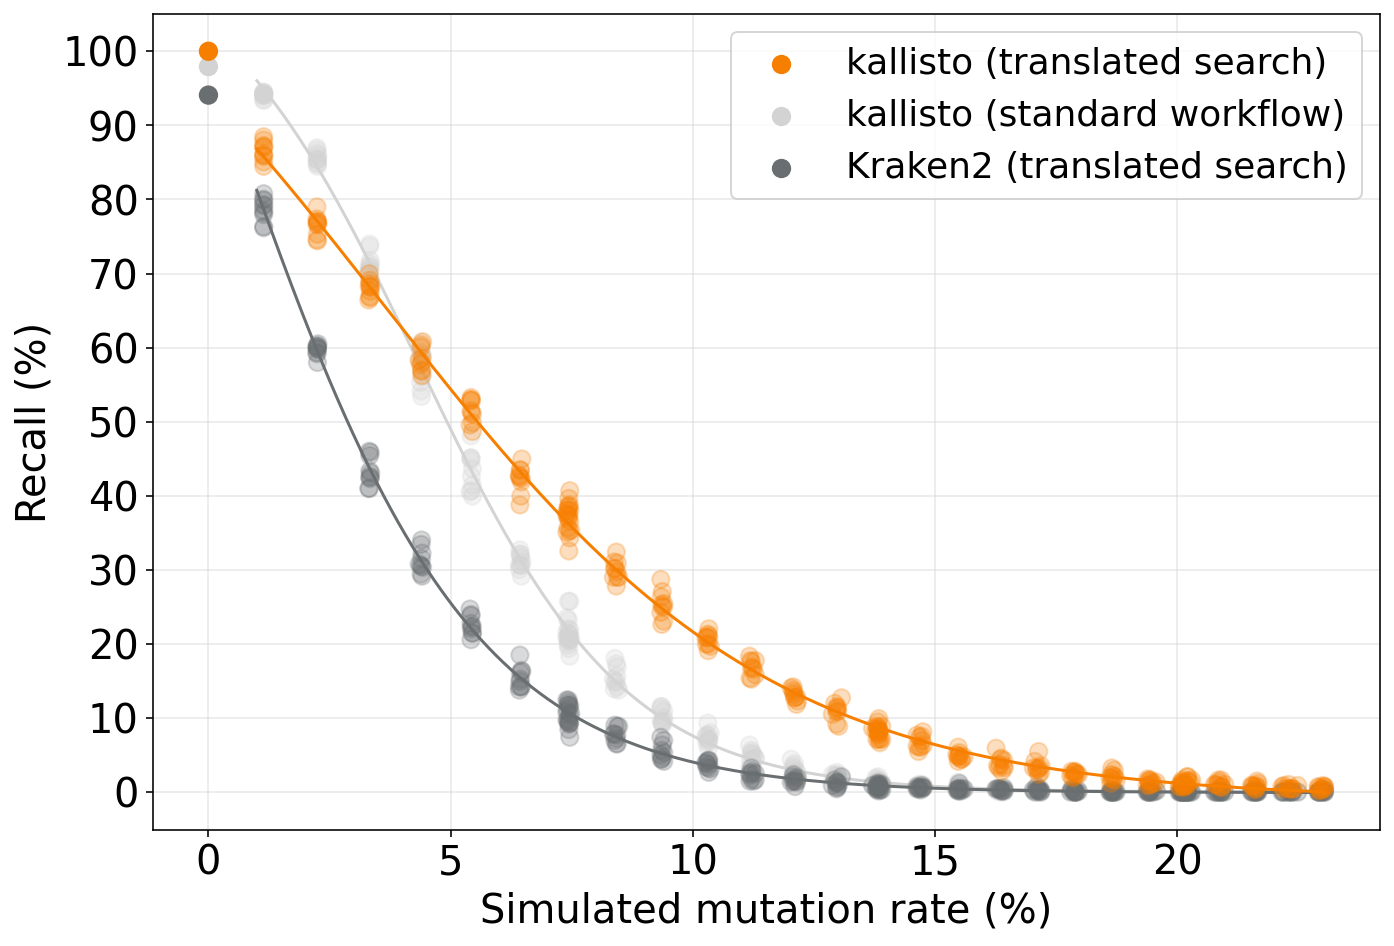

In [150]:
fig, ax = plt.subplots(figsize=(11, 7.5))
fontsize = 20
fontdict = {
    'weight': 'normal',
    'size': fontsize,
    }

# Plot recall percentages

kallisto_c = "#f77f00"
kallisto_sw_c = "lightgrey"
kraken_c = "#98c1d9"
kraken_t_c = "#696E70" # "#003049"

s = 75
# Define alphas
alphas = [1] + [0.25]*(len(df_recall)-1)

x = all_mutation_rates_flat
# y_25 = df["power_25perc"].values
# y_75 = df["power_75perc"].values
# y_std = df["STD"].values

# Plot actual data and fitted line
## Divide y values by (total_reads/100) to convert to %
ax.scatter(df_recall["mut_perc"].values, df_recall["kb"].values, color=kallisto_c, label="kallisto (translated search)", zorder=3, s=s, alpha=alphas)
# Plot prediction line
ax.plot(x_, kb_y_pred / (total_reads/100), color=kallisto_c, zorder=3)
# # Connect prediction to unmutated data point
# ax.plot([0, 1], np.array([kb_unmutated_ebov, kb_y_pred[0]]) / (total_reads/100), color=kallisto_c, zorder=2)

ax.scatter(df_recall["mut_perc"].values, df_recall["kb_standard"].values, color=kallisto_sw_c, label="kallisto (standard workflow)", zorder=1, s=s, alpha=alphas)
ax.plot(x_, kb_sw_y_pred / (total_reads/100), color=kallisto_sw_c, zorder=1)
# ax.plot([0, 1], np.array([kb_sw_unmutated_ebov, kb_sw_y_pred[0]]) / (total_reads/100), color=kallisto_sw_c, zorder=2)

ax.scatter(df_recall["mut_perc"].values, df_recall["kraken"].values, color=kraken_t_c, label="Kraken2 (translated search)", zorder=2, s=s, alpha=alphas)
ax.plot(x_, pkraken_y_pred / (total_reads/100), color=kraken_t_c, zorder=2)
# ax.plot([0, 1], np.array([pkraken_unmutated_ebov, pkraken_y_pred[0]]) / (total_reads/100), color=kraken_t_c, zorder=2)

# Plot percentiles
# # ax.plot(x, y_25, color=colors[i], ls="-.", alpha=0.5,label="25$^{th}$-75$^{th}$ %")
# ax.plot(x, y_25, color=colors[i], ls="-.", alpha=0.5)
# ax.plot(x, y_75, color=colors[i], ls="-.", alpha=0.5)
# # Fill space between percentile bands
# ax.fill_between(x, y_25, y_75, alpha=0.075, color=colors[i])

# Plot STD
# ax.plot(x, y+y_std, color=colors[i], ls="--", label="SD", alpha=0.3)
# ax.plot(x, y-y_std, color=colors[i], ls="--", alpha=0.3) 
# # Fill space between STD bands
# ax.fill_between(x, y+y_std, y-y_std, alpha=0.05, color=colors[i])

# Add legend
# ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left', fontsize=fontsize)
leg = ax.legend(fontsize=fontsize-2)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# Customize axes labels
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel("Recall (%)", fontdict=fontdict)

# Set major ticks 
ax.yaxis.set_major_locator(MultipleLocator(10))
# ax.yaxis.set_minor_locator(MultipleLocator(10))

# # Set y-axis bottom
# ax.set_ylim(bottom=-10)

# # Add thousands separator to y axis
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add grid
ax.grid(visible=True, which="both", color="lightgrey", alpha=0.5)
ax.set_axisbelow(True)
    
ax.set_xlabel("Simulated mutation rate (%)", fontdict=fontdict)

fig.savefig("figures/SNP_mutation_benchmark_recall.png", dpi=300, bbox_inches="tight")

plt.show()

Combine the two plots:

/tmp/ipykernel_147977/405950581.py:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


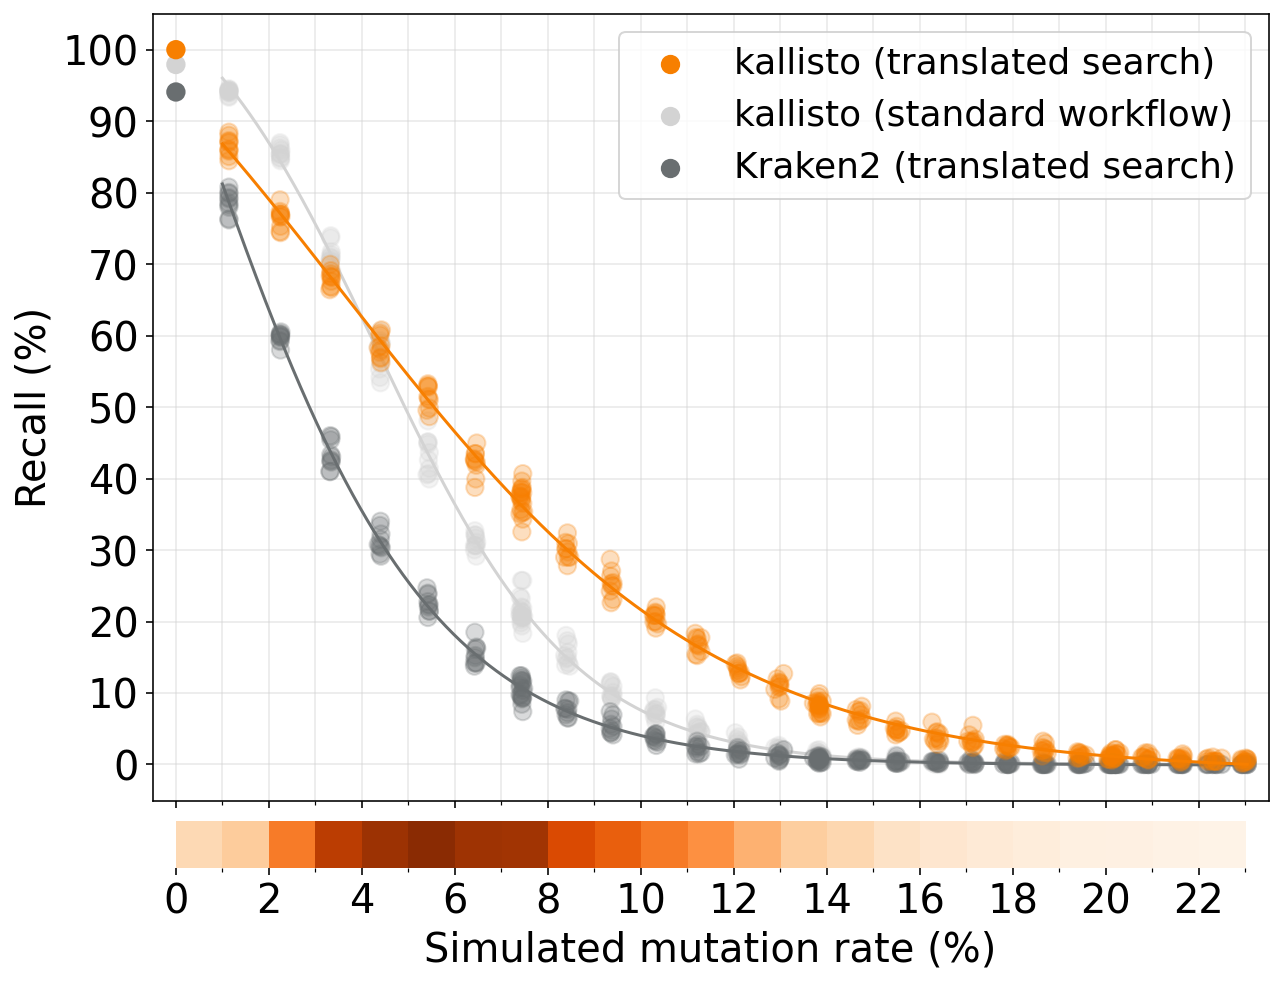

In [139]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=2, sharex=True, gridspec_kw={'height_ratios': [10, 1], 'hspace': 0.01})
fontsize = 20
fontdict = {
    'weight': 'normal',
    'size': fontsize,
    }

# Plot recall percentages
ax=axs[0]

kallisto_c = "#f77f00"
kallisto_sw_c = "lightgrey"
kraken_c = "#98c1d9"
kraken_t_c = "#696E70" # "#003049"

s = 75
# Define alphas
alphas = [1] + [0.25]*(len(df_recall)-1)

x = all_mutation_rates_flat
# y_25 = df["power_25perc"].values
# y_75 = df["power_75perc"].values
# y_std = df["STD"].values

# Plot actual data and fitted line
## Divide y values by (total_reads/100) to convert to %
ax.scatter(df_recall["mut_perc"].values, df_recall["kb"].values, color=kallisto_c, label="kallisto (translated search)", zorder=3, s=s, alpha=alphas)
# Plot prediction line
ax.plot(x_, kb_y_pred / (total_reads/100), color=kallisto_c, zorder=3)
# # Connect prediction to unmutated data point
# ax.plot([0, 1], np.array([kb_unmutated_ebov, kb_y_pred[0]]) / (total_reads/100), color=kallisto_c, zorder=2)

ax.scatter(df_recall["mut_perc"].values, df_recall["kb_standard"].values, color=kallisto_sw_c, label="kallisto (standard workflow)", zorder=1, s=s, alpha=alphas)
ax.plot(x_, kb_sw_y_pred / (total_reads/100), color=kallisto_sw_c, zorder=1)
# ax.plot([0, 1], np.array([kb_sw_unmutated_ebov, kb_sw_y_pred[0]]) / (total_reads/100), color=kallisto_sw_c, zorder=2)

ax.scatter(df_recall["mut_perc"].values, df_recall["kraken"].values, color=kraken_t_c, label="Kraken2 (translated search)", zorder=2, s=s, alpha=alphas)
ax.plot(x_, pkraken_y_pred / (total_reads/100), color=kraken_t_c, zorder=2)
# ax.plot([0, 1], np.array([pkraken_unmutated_ebov, pkraken_y_pred[0]]) / (total_reads/100), color=kraken_t_c, zorder=2)

# Plot percentiles
# # ax.plot(x, y_25, color=colors[i], ls="-.", alpha=0.5,label="25$^{th}$-75$^{th}$ %")
# ax.plot(x, y_25, color=colors[i], ls="-.", alpha=0.5)
# ax.plot(x, y_75, color=colors[i], ls="-.", alpha=0.5)
# # Fill space between percentile bands
# ax.fill_between(x, y_25, y_75, alpha=0.075, color=colors[i])

# Plot STD
# ax.plot(x, y+y_std, color=colors[i], ls="--", label="SD", alpha=0.3)
# ax.plot(x, y-y_std, color=colors[i], ls="--", alpha=0.3) 
# # Fill space between STD bands
# ax.fill_between(x, y+y_std, y-y_std, alpha=0.05, color=colors[i])

# Add legend
# ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left', fontsize=fontsize)
leg = ax.legend(fontsize=fontsize-2)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# Customize axes labels
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel("Recall (%)", fontdict=fontdict)

# Set major ticks 
ax.yaxis.set_major_locator(MultipleLocator(10))
# ax.yaxis.set_minor_locator(MultipleLocator(10))

# # Set y-axis bottom
# ax.set_ylim(bottom=-10)

# # Add thousands separator to y axis
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add grid
ax.grid(visible=True, which="both", color="lightgrey", alpha=0.5)
ax.set_axisbelow(True)


# Add heatmap
ax = axs[1]
im = ax.imshow(np.array([mean_dif]), extent=[0,23,-0.5,0.5], cmap="Oranges", vmin=0, vmax=30)

# # Add colorbar
# cb = plt.colorbar(im)
# cb.set_label(label="kallisto (translated search) recall (%) - Kraken2 (translated search) recall (%)", size=fontsize)
# cb.ax.tick_params(axis="both", labelsize=fontsize+6, length=8, width=2, pad=8) # Trying to match sns colorbar

# Set x-axis limit
ax.set_xlim(left=-0.5, right=23.5)
# Set major ticks 
ax.xaxis.set_major_locator(MultipleLocator(2))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))

for pos in ['right', 'top', 'bottom', 'left']: 
    ax.spines[pos].set_visible(False) 
    
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_yticks([])
ax.set_xlabel("Simulated mutation rate (%)", fontdict=fontdict)

fig.savefig("figures/SNP_mutation_benchmark_recall_heatmap.png", dpi=300, bbox_inches="tight")
# fig.savefig("figures/SNP_mutation_benchmark.svg", dpi=300, bbox_inches="tight")

plt.show()

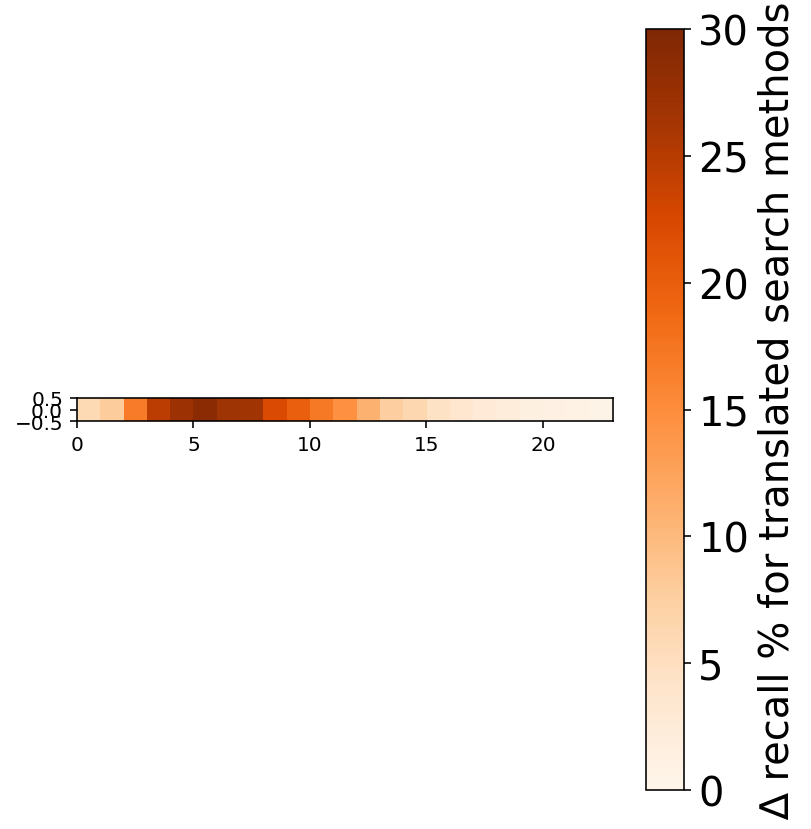

In [140]:
# Generate colorbar
fig, ax = plt.subplots(figsize=(6, 7))
im = ax.imshow(np.array([mean_dif]), extent=[0,23,-0.5,0.5], cmap="Oranges", vmin=0, vmax=30)

# Add colorbar
cb = plt.colorbar(im, shrink=1)
cb.set_label(label="∆ recall % for translated search methods", size=fontsize)
cb.ax.tick_params(axis="both", labelsize=fontsize)

fig.savefig("figures/SNP_mutation_benchmark_recall_colorbar.png", dpi=300, bbox_inches="tight")

# Plot F1 score
F1 score only makes sense for kallisto translated search since the other workflows do not have any other viruses in index to misalign to (except for Kraken2, but that workflow gave no hits without manually adding EBOV to index).

In [25]:
kb_y = []

for idx, snp_rate in enumerate(snp_rates):
    kb_y.append(df_kb[df_kb["snp_rate"] == snp_rate][[i for i in df_kb.columns if "f1" in i]].values[0])

    
# Flatten all lists of lists and add counts for unmutated sequences
kb_y = flatten(kb_y)
all_mutation_rates_flat = flatten(all_mutation_rates)

Fit sigmoid functions using non-linear least squares:

In [26]:
# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

xdata = all_mutation_rates_flat

# Estimate parameters and covariance

p0 = [max(kb_y), np.median(xdata), 1, min(kb_y)]
kb_popt, kb_pcov = curve_fit(sigmoid, xdata, kb_y, p0, method='dogbox', maxfev=5000)

x_ = np.linspace(1, max(all_mutation_rates_flat), 1000)

# Predict values
kb_y_pred = sigmoid(x_, *kb_popt)

Plot:

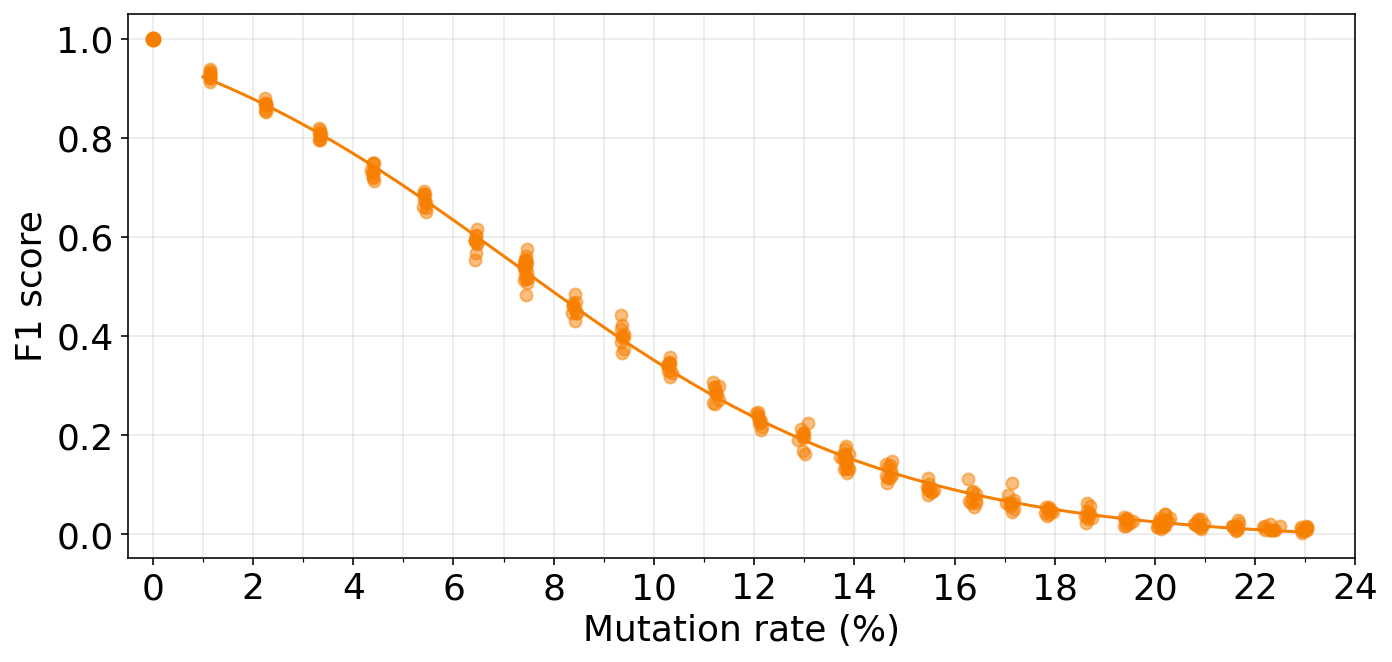

In [27]:
fig, ax = plt.subplots(figsize=(11, 5))
fontsize = 18
fontdict = {
    'weight': 'normal',
    'size': fontsize,
    }

kallisto_c = "#f77f00"
kraken_c = "#98c1d9"
kraken_t_c = "#003049"

total_reads = 676

x = all_mutation_rates_flat

# Plot actual data and fitted line
ax.scatter(0, kb_unmutated_f1, color=kallisto_c, zorder=3, s=50)
ax.scatter(x, np.array(kb_y), color=kallisto_c, zorder=3, alpha=0.5)
ax.plot(x_, kb_y_pred, color=kallisto_c, zorder=3)

# Set title
ax.set_title(f"", fontsize=fontsize+2)

# Customize axes labels
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlabel("Mutation rate (%)", fontdict=fontdict)
ax.set_ylabel("F1 score", fontdict=fontdict)

# Set major ticks to be multiples of 2
ax.xaxis.set_major_locator(MultipleLocator(2))
# ax.yaxis.set_major_locator(MultipleLocator(10))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(10))

# # Set x-axis limit
ax.set_xlim(left=-0.5, right=24)

# Add grid
ax.grid(visible=True, which="both", color="lightgrey", alpha=0.5)
ax.set_axisbelow(True)

fig.savefig("figures/SNP_mutation_benchmark_f1_scores.png", dpi=300, bbox_inches="tight")

plt.show()

# Plot precision

In [126]:
kb_y = []

for idx, snp_rate in enumerate(snp_rates):
    kb_y.append(df_kb[df_kb["snp_rate"] == snp_rate][[i for i in df_kb.columns if "precision" in i]].values[0])

    
# Flatten all lists of lists and add counts for unmutated sequences
kb_y = flatten(kb_y)
all_mutation_rates_flat = flatten(all_mutation_rates)

Fit sigmoid functions using non-linear least squares:

In [127]:
# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

xdata = all_mutation_rates_flat

p0 = [max(kb_y), np.median(xdata), 1, min(kb_y)]
kb_popt, kb_pcov = curve_fit(sigmoid, xdata, kb_y, p0, method='dogbox', maxfev=5000)

x_ = np.linspace(1, max(all_mutation_rates_flat), 1000)

# Predict values
kb_y_pred = sigmoid(x_, *kb_popt)

Plot:

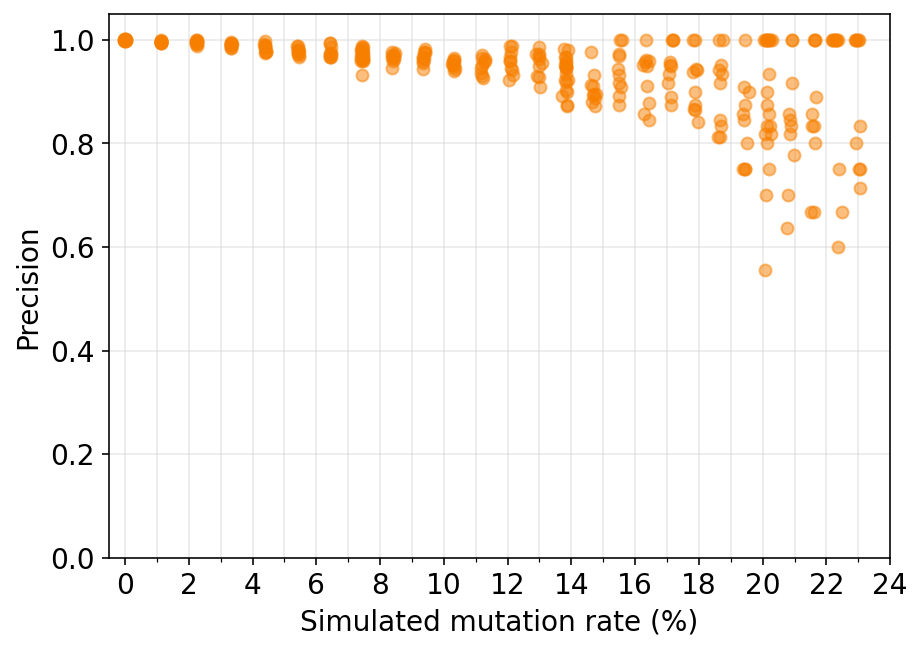

In [129]:
fig, ax = plt.subplots(figsize=(7, 5))
fontsize = 14
fontdict = {
    'weight': 'normal',
    'size': fontsize,
    }

kallisto_c = "#f77f00"

total_reads = 676

x = all_mutation_rates_flat

# Plot actual data and fitted line
ax.scatter(0, kb_unmutated_precision, color=kallisto_c, zorder=3, s=50)
ax.scatter(x, np.array(kb_y), color=kallisto_c, zorder=3, alpha=0.5)
# ax.plot(x_, kb_y_pred, color=kallisto_c, zorder=3)

# Set title
ax.set_title(f"", fontsize=fontsize+2)

# Customize axes labels
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlabel("Simulated mutation rate (%)", fontdict=fontdict)
ax.set_ylabel("Precision", fontdict=fontdict)

# Set major ticks to be multiples of 2
ax.xaxis.set_major_locator(MultipleLocator(2))
# ax.yaxis.set_major_locator(MultipleLocator(10))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(10))

# # Set x-axis limit
ax.set_xlim(left=-0.5, right=24)

# # Set y-axis lim
ax.set_ylim(bottom=0, top=1.05)

# # Add thousands separator to y axis
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add grid
ax.grid(visible=True, which="both", color="lightgrey", alpha=0.5)
ax.set_axisbelow(True)

fig.savefig("figures/SNP_mutation_benchmark_precision.png", dpi=300, bbox_inches="tight")
# fig.savefig("figures/SNP_mutation_benchmark.svg", dpi=300, bbox_inches="tight")

plt.show()

In [31]:
# fig, ax = plt.subplots(figsize=(8,8))
# fontsize = 18
# fontdict = {
#     'weight': 'normal',
#     'size': fontsize,
#     }
# label_color = "white"

# x = all_mutation_rates_flat
# # y_25 = df["power_25perc"].values
# # y_75 = df["power_75perc"].values
# # y_std = df["STD"].values

# # Plot actual data and fitted line
# ## Divide y values by 0.3 to convert to recall %
# # Manually added results from unmutated seqs alignment (!!! to-do: aumatomate this!!)
# ax.scatter([0] + x, np.array([30] + kb_y)/0.3, color="#c07fbe", label="kallisto (translated search)", zorder=3, alpha=0.5)
# ax.plot(x_, kb_y_pred/0.3, color="#c07fbe", zorder=2)

# ax.scatter([0] + x, np.array([30] + kraken_y)/0.3, color="dodgerblue", label="Kraken2", zorder=1, alpha=0.5)
# ax.plot(x_, kraken_y_pred/0.3, color="dodgerblue", zorder=1)

# ax.scatter([0] + x, np.array([20] + pkraken_y)/0.3, color="darkturquoise", label="Kraken2 (translated search)", zorder=2, alpha=0.5)
# ax.plot(x_, pkraken_y_pred/0.3, color="darkturquoise", zorder=3)

# # Plot percentiles
# # # ax.plot(x, y_25, color=colors[i], ls="-.", alpha=0.5,label="25$^{th}$-75$^{th}$ %")
# # ax.plot(x, y_25, color=colors[i], ls="-.", alpha=0.5)
# # ax.plot(x, y_75, color=colors[i], ls="-.", alpha=0.5)
# # # Fill space between percentile bands
# # ax.fill_between(x, y_25, y_75, alpha=0.075, color=colors[i])

# # Plot STD
# # ax.plot(x, y+y_std, color=colors[i], ls="--", label="SD", alpha=0.3)
# # ax.plot(x, y-y_std, color=colors[i], ls="--", alpha=0.3) 
# # # Fill space between STD bands
# # ax.fill_between(x, y+y_std, y-y_std, alpha=0.05, color=colors[i])

# # Add legend
# # ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left', fontsize=fontsize)
# leg = ax.legend(fontsize=fontsize-2)
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
    
# # lh.set_alpha(0)
# # leg.get_texts()[-1].set_alpha(0)

# # Set title
# ax.set_title(f"", fontsize=fontsize+2)

# # Customize axes labels
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.set_xlabel("Mutation rate (%)", fontdict=fontdict, color=label_color)
# ax.set_ylabel("Recall (%)", fontdict=fontdict, color=label_color)

# # Set major ticks to be multiples of 2
# ax.xaxis.set_major_locator(MultipleLocator(2))
# ax.yaxis.set_major_locator(MultipleLocator(10))
# # For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# # ax.yaxis.set_minor_locator(MultipleLocator(10))

# # # Set x-axis limit
# ax.set_xlim(left=-0.5, right=24)

# # # Set y-axis bottom
# # ax.set_ylim(bottom=-10)

# # # Add thousands separator to y axis
# # ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# ax.grid(True, which="both", color="grey")
# ax.set_axisbelow(True)

# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.tick_params(axis='both', colors='white') 

# fig.savefig("figures/SNP_mutation_benchmark_white.png", dpi=300, bbox_inches="tight", transparent=True)

# plt.show()